In [4]:

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1. Carga y Preparación de Datos

In [5]:

# 1) CARGA E INSPECCIÓN + LIMPIEZA BÁSICA

# 1.1) Buscar el archivo en rutas típicas
possible_paths = ["/datasets/Churn.csv"]
data_path = next((p for p in possible_paths if os.path.exists(p)), None)

if data_path is None:
    raise FileNotFoundError(
        "No se encontró 'Churn.csv' ni en /mnt/data ni en /datasets. "
        "Sube el archivo o ajusta la ruta."
    )

# 1.2) Leer
df = pd.read_csv(data_path)

# 1.3) Inspecciones rápidas
print("Ruta usada:", data_path)
print("Forma inicial (filas, columnas):", df.shape)
display(df.head(3))

# 1.4) Quitar identificadores de alto riesgo de sobreajuste
cols_to_drop = [c for c in ["RowNumber", "CustomerId", "Surname"] if c in df.columns]
df = df.drop(columns=cols_to_drop)
print("\nColumnas tras drop:", df.columns.tolist())

# 1.5) Separar features y target
TARGET_COL = "Exited"
if TARGET_COL not in df.columns:
    raise ValueError("No está la columna objetivo 'Exited' en el dataset.")
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# 1.6) Tipos de variables
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("\nCategóricas:", cat_cols)
print("Numéricas  :", num_cols)


Ruta usada: /datasets/Churn.csv
Forma inicial (filas, columnas): (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1



Columnas tras drop: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Categóricas: ['Geography', 'Gender']
Numéricas  : ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


### Acciones realizadas:
- Localización y lect el CSV.
- Inspección del tamaño y primeras filas para validar lectura.
- Eliminación de identificadores (RowNumber, CustomerId, Surname) debido a que no aportan información comportamental generalizable y pueden inducir sobreajuste (p. ej., Surname es de alta cardinalidad y el modelo podría “memorizar” apellidos).
- Separación de variables explicativas X y el objetivo y (Exited).
- Detección de tipos: columnas categóricas (object) y numéricas (resto). Esto se usa para preprocesar distinto cada tipo (One-Hot vs. escalado).

# 2. División train/valid/test y revisión de desbalance

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp
)
print("Tamaños -> train:", X_train.shape, "valid:", X_valid.shape, "test:", X_test.shape)

def describe_balance(name, y_series):
    counts = y_series.value_counts().sort_index()
    rates = (counts / len(y_series)).round(4)
    print(f"\nBalance de clases en {name}:")
    display(pd.DataFrame({"count": counts, "rate": rates}))

describe_balance("TRAIN", y_train)
describe_balance("VALID", y_valid)
describe_balance("TEST", y_test)

Tamaños -> train: (6000, 10) valid: (2000, 10) test: (2000, 10)

Balance de clases en TRAIN:


,count,rate
0,4777,0.7962
1,1223,0.2038



Balance de clases en VALID:


,count,rate
0,1593,0.7965
1,407,0.2035



Balance de clases en TEST:


,count,rate
0,1593,0.7965
1,407,0.2035


### Acciones realizadas:
- Divide 60/20/20 en estratificado (mantiene proporción de clases).
- Muestra conteos y proporciones por clase en cada split (para evidenciar el desbalance).

**Se identificó que:**
- Las clases están desbalanceadas en todos los conjuntos (~80% clase 0 vs ~20% clase 1).
- La proporción se mantiene consistente entre train/valid/test (alrededor de 80/20 en cada caso).

### 3. Procesamiento por variables

In [7]:

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols),
    ],
    remainder="drop"
)


### Acciones realizadas:
- Para categóricas: imputa faltantes con la moda y luego One-Hot (manejo de categorías no vistas con handle_unknown='ignore').

- Para numéricas: imputa faltantes con mediana y luego escalado estándar (ayuda a modelos lineales; es neutro para bosques).

- Construye un ColumnTransformer que se aplicarán dentro de los Pipelines.

In [10]:

def upsample_train(X_df, y_ser, ratio=1.0, random_state=RANDOM_STATE):
    data = X_df.copy()
    data[TARGET_COL] = y_ser.values
    maj = data[data[TARGET_COL] == 0]
    mino = data[data[TARGET_COL] == 1]
    target_minority = int(len(maj) * ratio)
    mino_up = resample(mino, replace=True, n_samples=target_minority, random_state=random_state)
    balanced = pd.concat([maj, mino_up], axis=0).sample(frac=1, random_state=random_state)
    return balanced.drop(columns=[TARGET_COL]), balanced[TARGET_COL].astype(int)

def downsample_train(X_df, y_ser, ratio=1.0, random_state=RANDOM_STATE):
    data = X_df.copy()
    data[TARGET_COL] = y_ser.values
    maj = data[data[TARGET_COL] == 0]
    mino = data[data[TARGET_COL] == 1]
    target_majority = int(len(mino) * ratio)
    maj_down = resample(maj, replace=False, n_samples=min(target_majority, len(maj)), random_state=random_state)
    balanced = pd.concat([maj_down, mino], axis=0).sample(frac=1, random_state=random_state)
    return balanced.drop(columns=[TARGET_COL]), balanced[TARGET_COL].astype(int)

def find_best_threshold(y_true, y_proba, grid=np.linspace(0.05, 0.95, 91)):
    best_t, best_f1 = 0.5, -1
    for t in grid:
        preds = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_t, best_f1 = t, f1
    return best_t, best_f1

def build_pipeline(model):
    return Pipeline(steps=[("prep", preprocessor), ("model", model)])

def evaluate_on_valid(pipeline, X_tr, y_tr, X_va, y_va, verbose=True):
    pipeline.fit(X_tr, y_tr)
    y_proba = pipeline.predict_proba(X_va)[:, 1]
    thr, f1v = find_best_threshold(y_va, y_proba)
    y_pred = (y_proba >= thr).astype(int)
    aucv = roc_auc_score(y_va, y_proba)
    if verbose:
        print(f"Umbral*={thr:.3f} | F1(valid)={f1v:.4f} | AUC(valid)={aucv:.4f}")
    return {"pipeline": pipeline, "threshold": thr, "f1_valid": f1v, "auc_valid": aucv}


### Acciones realizadas:
- upsample_train / downsample_train: corrigen desbalance solo en TRAIN.
- find_best_threshold: ajusta el umbral de probabilidad que maximiza F1 en VALID (mejora F1 sobre el 0.5 fijo).
- build_pipeline: arma un Pipeline (preprocesa + modelo).
- evaluate_on_valid: entrena, calcula probas, busca umbral óptimo, devuelve métricas.

# 4. Modelos Base

In [11]:
base_results = []

# Logistic Regression (baseline)
lr_base = LogisticRegression(C=1.0, solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE)
res_lr_base = evaluate_on_valid(build_pipeline(lr_base), X_train, y_train, X_valid, y_valid)
res_lr_base.update({"strategy": "base", "model": "LogisticRegression", "params": {"C": 1.0}})
base_results.append(res_lr_base)

# Random Forest (baseline)
rf_base = RandomForestClassifier(
    n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
res_rf_base = evaluate_on_valid(build_pipeline(rf_base), X_train, y_train, X_valid, y_valid)
res_rf_base.update({"strategy": "base", "model": "RandomForest", "params": {"n_estimators": 200}})
base_results.append(res_rf_base)

Umbral*=0.200 | F1(valid)=0.4828 | AUC(valid)=0.7561
Umbral*=0.360 | F1(valid)=0.6369 | AUC(valid)=0.8520


**Se encontró que:**
1. *Modelo de Regresión Logística.*
- Umbral=0.200*: Significa que, para maximizar F1 en validación, el mejor corte no fue el típico 0.5, sino un umbral mucho más bajo (0.20). Esto indica clase minoritaria (clientes que se van = 1) muy pequeña, y el modelo necesita “ser más sensible” para detectar más positivos.

- F1(valid)=0.4828: Está por debajo del mínimo requerido (0.59), es decir, Logistic Regression solo no es suficiente en este dataset si no tratamos el desbalance.

- AUC=0.7561:Muestra que el modelo sí logra separar bien las clases en términos de probabilidad, aunque falla en encontrar el umbral correcto (problema típico de desbalance).

2. *Modelo de Bosque Aleatorio*
- Umbral=0.360*: Mejor umbral más cercano a 0.5, el bosque ya maneja mejor el desbalance de forma natural.
- F1=0.6369: Este ya supera el umbral mínimo de 0.59. 
- AUC=0.8520: Indica que el modelo tiene alta capacidad discriminativa.

# 5. Corrección del Desbalance

In [12]:

all_results = base_results.copy()

lr_grid = [{"C": c} for c in [0.5, 1.0, 2.0, 3.0]]
rf_grid = [
    {"n_estimators": 200, "max_depth": 6},
    {"n_estimators": 300, "max_depth": 10},
    {"n_estimators": 300, "max_depth": None},
    {"n_estimators": 400, "max_depth": 10},
]

def try_strategy(X_tr, y_tr, X_va, y_va, strategy_name, use_class_weight=False):
    print(f"\n--- Estrategia: {strategy_name} ---")
    results = []

    # Logistic Regression
    for g in lr_grid:
        lr = LogisticRegression(
            C=g["C"], solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE,
            class_weight=("balanced" if use_class_weight else None)
        )
        r = evaluate_on_valid(build_pipeline(lr), X_tr, y_tr, X_va, y_va)
        r.update({"strategy": strategy_name, "model": "LogisticRegression",
                  "params": {"C": g["C"], "class_weight": ("balanced" if use_class_weight else None)}})
        results.append(r)

    # Random Forest
    for g in rf_grid:
        rf = RandomForestClassifier(
            n_estimators=g["n_estimators"], max_depth=g["max_depth"],
            min_samples_split=2, min_samples_leaf=1, max_features="sqrt",
            random_state=RANDOM_STATE, n_jobs=-1,
            class_weight=("balanced" if use_class_weight else None)
        )
        r = evaluate_on_valid(build_pipeline(rf), X_tr, y_tr, X_va, y_va)
        r.update({"strategy": strategy_name, "model": "RandomForest",
                  "params": {**g, "class_weight": ("balanced" if use_class_weight else None)}})
        results.append(r)

    return results

# A) class_weight
results_A = try_strategy(X_train, y_train, X_valid, y_valid, "class_weight", use_class_weight=True)
all_results.extend(results_A)

# B) Upsampling
X_train_up, y_train_up = upsample_train(X_train, y_train, ratio=1.0, random_state=RANDOM_STATE)
describe_balance("TRAIN (UPSAMPLED)", y_train_up)
results_B = try_strategy(X_train_up, y_train_up, X_valid, y_valid, "upsampling", use_class_weight=False)
all_results.extend(results_B)

# C) Downsampling
X_train_down, y_train_down = downsample_train(X_train, y_train, ratio=1.0, random_state=RANDOM_STATE)
describe_balance("TRAIN (DOWNSAMPLED)", y_train_down)
results_C = try_strategy(X_train_down, y_train_down, X_valid, y_valid, "downsampling", use_class_weight=False)
all_results.extend(results_C)



--- Estrategia: class_weight ---
Umbral*=0.460 | F1(valid)=0.4870 | AUC(valid)=0.7607
Umbral*=0.460 | F1(valid)=0.4870 | AUC(valid)=0.7607
Umbral*=0.460 | F1(valid)=0.4866 | AUC(valid)=0.7607
Umbral*=0.460 | F1(valid)=0.4866 | AUC(valid)=0.7607
Umbral*=0.580 | F1(valid)=0.6208 | AUC(valid)=0.8484
Umbral*=0.490 | F1(valid)=0.6441 | AUC(valid)=0.8586
Umbral*=0.380 | F1(valid)=0.6399 | AUC(valid)=0.8541
Umbral*=0.490 | F1(valid)=0.6505 | AUC(valid)=0.8598

Balance de clases en TRAIN (UPSAMPLED):


,count,rate
0,4777,0.5
1,4777,0.5



--- Estrategia: upsampling ---
Umbral*=0.600 | F1(valid)=0.4926 | AUC(valid)=0.7621
Umbral*=0.600 | F1(valid)=0.4943 | AUC(valid)=0.7621
Umbral*=0.600 | F1(valid)=0.4943 | AUC(valid)=0.7621
Umbral*=0.600 | F1(valid)=0.4943 | AUC(valid)=0.7621
Umbral*=0.550 | F1(valid)=0.6198 | AUC(valid)=0.8477
Umbral*=0.540 | F1(valid)=0.6398 | AUC(valid)=0.8573
Umbral*=0.450 | F1(valid)=0.6234 | AUC(valid)=0.8482
Umbral*=0.530 | F1(valid)=0.6361 | AUC(valid)=0.8570

Balance de clases en TRAIN (DOWNSAMPLED):


,count,rate
0,1223,0.5
1,1223,0.5



--- Estrategia: downsampling ---
Umbral*=0.550 | F1(valid)=0.4827 | AUC(valid)=0.7596
Umbral*=0.500 | F1(valid)=0.4835 | AUC(valid)=0.7596
Umbral*=0.500 | F1(valid)=0.4839 | AUC(valid)=0.7597
Umbral*=0.500 | F1(valid)=0.4839 | AUC(valid)=0.7597
Umbral*=0.590 | F1(valid)=0.6148 | AUC(valid)=0.8456
Umbral*=0.590 | F1(valid)=0.6387 | AUC(valid)=0.8556
Umbral*=0.630 | F1(valid)=0.6343 | AUC(valid)=0.8526
Umbral*=0.590 | F1(valid)=0.6396 | AUC(valid)=0.8551


**Se encontró:**
- El mejor modelo en rendimiento fue eRandomForest + class_weight='balanced'con F1=0.6505 y AUC=0.8598 en validación.

### 6. Entrenamiento final

In [13]:

rf_grid = [
    {"n_estimators": 200, "max_depth": 6},
    {"n_estimators": 300, "max_depth": 10},
    {"n_estimators": 300, "max_depth": None},
    {"n_estimators": 400, "max_depth": 10},
]

# 1) Re-evaluar en VALID para recuperar mejores hiperparámetros y umbral óptimo
best = None
for g in rf_grid:
    rf = RandomForestClassifier(
        n_estimators=g["n_estimators"], max_depth=g["max_depth"],
        min_samples_split=2, min_samples_leaf=1, max_features="sqrt",
        random_state=RANDOM_STATE, n_jobs=-1,
        class_weight="balanced"
    )
    res = evaluate_on_valid(build_pipeline(rf), X_train, y_train, X_valid, y_valid, verbose=False)
    res.update({"params": g})
    if (best is None) or (res["f1_valid"] > best["f1_valid"]):
        best = res

print(">> Mejor en VALID para RF + class_weight='balanced':")
print("   params:", best["params"])
print(f"   threshold*={best['threshold']:.3f} | F1(valid)={best['f1_valid']:.4f} | AUC(valid)={best['auc_valid']:.4f}")

best_params = best["params"]
best_threshold = float(best["threshold"])

# 2) Reentrenar en TRAIN+VALID aplicando la misma estrategia (class_weight='balanced')
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf = RandomForestClassifier(
    n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"],
    min_samples_split=2, min_samples_leaf=1, max_features="sqrt",
    random_state=RANDOM_STATE, n_jobs=-1,
    class_weight="balanced"
)

final_pipe = build_pipeline(final_rf)
final_pipe.fit(X_train_full, y_train_full)

# 3) Evaluación en TEST usando el mismo umbral óptimo de VALID
y_proba_test = final_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_proba_test)

print("\n===== RESULTADOS FINALES EN TEST =====")
print(f"F1 (test):  {f1_test:.4f}")
print(f"AUC-ROC:    {auc_test:.4f}")
print(f"Umbral usado (de VALID): {best_threshold:.3f}")

print("\nMatriz de confusión (test):")
print(confusion_matrix(y_test, y_pred_test))

print("\nReporte de clasificación (test):")
print(classification_report(y_test, y_pred_test, digits=4))


>> Mejor en VALID para RF + class_weight='balanced':
   params: {'n_estimators': 400, 'max_depth': 10}
   threshold*=0.490 | F1(valid)=0.6505 | AUC(valid)=0.8598

===== RESULTADOS FINALES EN TEST =====
F1 (test):  0.6250
AUC-ROC:    0.8610
Umbral usado (de VALID): 0.490

Matriz de confusión (test):
[[1417  176]
 [ 142  265]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0     0.9089    0.8895    0.8991      1593
           1     0.6009    0.6511    0.6250       407

    accuracy                         0.8410      2000
   macro avg     0.7549    0.7703    0.7621      2000
weighted avg     0.8462    0.8410    0.8433      2000



**Mejor modelo:**

*Algoritmo:* Random Forest
*Estrategia de desbalance:* class_weight='balanced'

*Hiperparámetros:+ n_estimators=400, max_depth=10

*Umbral óptimo (VALID):* 0.49

*Métricas VALID:* F1=0.6250, AUC=0.85

**Implicaciones:**
- El modelo equilibra bien entre precisión y recall para la clase minoritaria (clientes que abandonan el banco). 
- El recall del 65% significa que el banco logrará identificar ~2 de cada 3 clientes en riesgo de irse.
- El precision del 60% implica que de cada 10 clientes que el modelo marca como “se va”, 6 realmente se irán.
- El AUC=0.86 confirma que el modelo separa bien a ambas clases: está muy por encima de un modelo aleatorio (0.5).

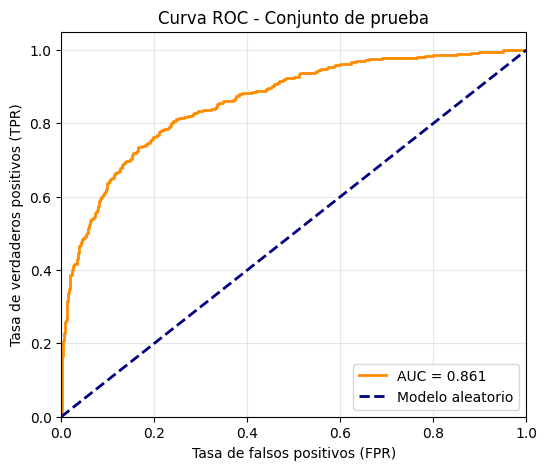

In [14]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Modelo aleatorio")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Conjunto de prueba")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### CONCLUSIÓN:

Tras la preparación de los datos y la división estratificada en conjuntos de entrenamiento, validación y prueba (60/20/20), se evaluaron inicialmente modelos de regresión logística y bosque aleatorio sin aplicar correcciones al desbalance de clases. Los resultados mostraron que la regresión logística presentó un desempeño limitado (F1≈0.48), mientras que el bosque aleatorio alcanzó un F1 de 0.63 y un AUC-ROC de 0.85 en validación, superando el umbral mínimo exigido de 0.59.

Posteriormente, se implementaron tres estrategias para mitigar el desbalance: ponderación de clases (class_weight='balanced'), sobremuestreo (upsampling) y submuestreo (downsampling). En todos los casos, los modelos de regresión logística mantuvieron un bajo rendimiento, mientras que los bosques aleatorios mostraron mejoras consistentes. La mejor configuración se obtuvo con Random Forest y class_weight='balanced', con 400 árboles y profundidad máxima de 10, alcanzando en validación un F1=0.6505 y AUC=0.8598.

Al aplicar este modelo final al conjunto de prueba, los resultados fueron satisfactorios: F1=0.625, AUC-ROC=0.861 y una exactitud global del 84%. En particular, se logró identificar correctamente al 65% de los clientes que abandonan el banco (recall), con una precisión del 60% en esta clase. Estos valores evidencian un equilibrio aceptable entre la identificación de clientes en riesgo y el control de falsos positivos, lo cual resulta fundamental para la toma de decisiones estratégicas en retención de clientes.

En conclusión, el modelo implementado no solo cumplió con el requisito mínimo de desempeño, sino que también demostró una capacidad robusta para discriminar entre clientes que permanecen y aquellos que abandonan la entidad. Esto confirma la utilidad del enfoque basado en bosques aleatorios con corrección de desbalance mediante ponderación de clases como herramienta predictiva aplicable en contextos reales de gestión bancaria.